In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Import common tensorflow layers and activations
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Layer
from tensorflow.keras.layers import Lambda, Multiply, Add 
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras import Input

In [3]:
class GLULayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(GLULayer, self).__init__()
        self.forward = None
        self.units = units*2

    def call(self, inputs):
        x = Dense(self.units)(inputs)
        x1, x2 = tf.split(x, 2, axis=-1)
        return x1 * sigmoid(x2)

In [4]:
# Test Glu Layer on normal data
glu = GLULayer(10)
x = tf.random.normal((1, 7))
y = glu(x)
y

2023-04-25 18:48:43.475519: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-25 18:48:43.475615: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (al3615): /proc/driver/nvidia/version does not exist
2023-04-25 18:48:43.476388: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.23215452,  0.9407819 ,  0.04402405,  0.07932476,  0.28471863,
        -0.23389688, -0.30013853,  0.10115302, -0.8447979 ,  0.5125168 ]],
      dtype=float32)>

In [5]:
class SharedFeatureLayer(Layer):
    def __init__(self, units, depth=2, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.units = units
        self.depth = depth

    def build(self, input_shape):
        super().build(input_shape)
        _in = Input(shape=input_shape[1:])
        x = _in
        for i in range(self.depth):
            y = Dense(self.units)(x)
            y = BatchNormalization()(y)
            y = GLULayer(self.units)(y)
            # Skip first residual connection as input is not guaranteed to be same shape as num units
            if i > 0:
                x = (x + y)*0.5**0.5
            else:
                x = y
        self.forward = Model(_in, y)
    
    def call(self, inputs, *args, **kwargs):
        return self.forward(inputs)

In [6]:
# Test Shared Feature Layer on normal data
sfl = SharedFeatureLayer(units=10)
x = tf.random.normal((1, 7))
y = sfl(x)
y

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.15125495, -0.09653445, -0.18121697, -0.10523367,  0.09352842,
         0.00124904,  0.06591543, -0.03764122, -0.36132282, -0.12428884]],
      dtype=float32)>

In [7]:
class FeatureTransformer(Layer):
    def __init__(self, units, shared_layer, depth=2, *args, **kwargs):
        super().__init__( *args, **kwargs )
        self.units = units
        self.shared_layer = shared_layer
        self.depth = depth
        self.forward = None

    def build(self, input_shape):
        super().build(input_shape)
        # self.shared_layer.build(input_shape)
        _in = Input(shape=input_shape[1:])
        shared_output = self.shared_layer(_in)
        x = shared_output
        for _ in range(self.depth):
            y = Dense(self.units)(x)
            y = BatchNormalization()(y)
            y = GLULayer(self.units)(y)
            x = (x + y)*0.5**0.5
        self.forward = Model(_in, x)
    
    def call(self, data):
        return self.forward(data)

In [8]:
# test Feature Transformer on normal data
sfl = SharedFeatureLayer(units=10)
ft = FeatureTransformer(units=10, shared_layer=sfl)
x = tf.random.normal((1, 7))
y = ft(x)
y

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.01654652, -0.02763228,  0.09033699, -0.08615315, -0.00484035,
        -0.07045442,  0.07713187, -0.05966711,  0.00776217, -0.07103664]],
      dtype=float32)>

In [12]:
class AttentiveTransformer(Model):
    def __init__(self, units, gamma=1.3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.units = units
        self.gamma = tf.constant(gamma, dtype=tf.float32)
        self.forward = None
    
    def build(self, input_shape):
        # super().build(input_shape)
        _in = Input(shape=input_shape[1:], name=f"{self._name}_input")
        x = Dense(self.units, name=f"{self._name}_dense")(_in)
        x = BatchNormalization(name=f"{self._name}_BN")(x)
        x = softmax(x, axis=-1)
        self.forward = Model(_in, x)
    
    def call(self, data):
        return self.forward(data)
        

In [16]:
class TabNet(Model):
    def __init__(self, dim_features, dim_attention, dim_output, num_steps=3, gamma=1.3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_step = num_steps
        self.dim_features = dim_features
        self.dim_attention = dim_attention # Currently keep it simple and just have equal attention and pre_output dimensions
        self.dim_pre_output = dim_attention
        self.dim_output = dim_output
        self.gamma = tf.constant(gamma)

        self.shared_layer = SharedFeatureLayer(units=dim_attention*2, depth=2, name="shared_feature_layer")
        self.feature_transformers = [FeatureTransformer(units=dim_attention*2, shared_layer=self.shared_layer, name="init_feature_transformer")]
        self.attention_layers = []

        # Define model forward pass

        _in = Input(shape=(self.dim_features,), name="tabnet_input")
        norm_in = BatchNormalization(name="norm_in")(_in)
        

        d0, a_i = tf.split(self.feature_transformers[0](norm_in), num_or_size_splits=2, axis=-1)
        priors = []
        d = tf.zeros_like(d0)
        for i in range(num_steps):
            new_attention_layer = AttentiveTransformer(units=self.dim_features, name=f"attention_layer_{i+1}")
            new_feature_layer = FeatureTransformer(units=dim_attention*2, shared_layer=self.shared_layer, name=f"feature_transformer_{i+1}")

            candidate_mask = new_attention_layer(a_i)
            for prior in priors:
                candidate_mask *= (self.gamma-prior)
            priors.append(candidate_mask)

            masked_input = tf.math.multiply(norm_in, candidate_mask)

            new_features = new_feature_layer(masked_input)
            d_i, a_i = tf.split(new_features, num_or_size_splits=2, axis=-1)
            d = d + relu(d_i)

            self.attention_layers.append(new_attention_layer)
            self.feature_transformers.append(new_feature_layer)
        _out = Dense(dim_output)(d)
        self.forward = Model(_in, _out)
    
    def call(self, data):
        return self.forward(data)


In [18]:
# test TabNet on normal data
tabnet = TabNet(dim_features=7, dim_attention=10, dim_output=1)
x = tf.random.normal((10, 7))
y = tabnet(x)
y

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 0.00054083],
       [-0.01297351],
       [-0.0210685 ],
       [-0.01517237],
       [-0.00419401],
       [-0.04388188],
       [-0.02505299],
       [-0.05104399],
       [-0.02460882],
       [-0.08395625]], dtype=float32)>

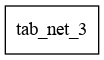

In [21]:
tf.keras.utils.plot_model(tabnet, expand_nested=True, show_layer_names=True, )